<a href="https://colab.research.google.com/github/jessicanadalete/health_insurance_cross_sell/blob/main/health_insurance_cross_sell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0.0 Imports

In [1]:
pip install inflection

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection

##0.1 Loading dataset

In [3]:
df_raw = pd.read_csv('train.csv', low_memory=False)

## 1.0 Data Description

In [4]:
#creating a copy of data
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [6]:
old_columns = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
               'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
               'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))

df1.columns = new_columns

## 1.1 Data Dimension

In [7]:
df1.shape

(381109, 12)

## 1.2 Data Types

In [8]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [9]:
df1.dtypes

,0
id,int64
gender,object
age,int64
driving_license,int64
region_code,float64
previously_insured,int64
vehicle_age,object
vehicle_damage,object
annual_premium,float64
policy_sales_channel,float64


In [10]:
df1['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [11]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.3 Check NAs

In [12]:
#checking the sum of NA in each column
df1.isna().sum()

,0
id,0
gender,0
age,0
driving_license,0
region_code,0
previously_insured,0
vehicle_age,0
vehicle_damage,0
annual_premium,0
policy_sales_channel,0


3.4 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [14]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


#2.0 Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
#damage column transformation

df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == "Yes" else 0)

#vehicle age transformation

df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 0 if x == "< 1 Year" else 1 if x== "1-2 Year" else 2)

# 3.0 Data Filtering

In [17]:
df3 = df2.copy()

#4.0 Exploraotry Data Analysis

In [18]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#####Analysing variables x reponse

In [19]:
#gender

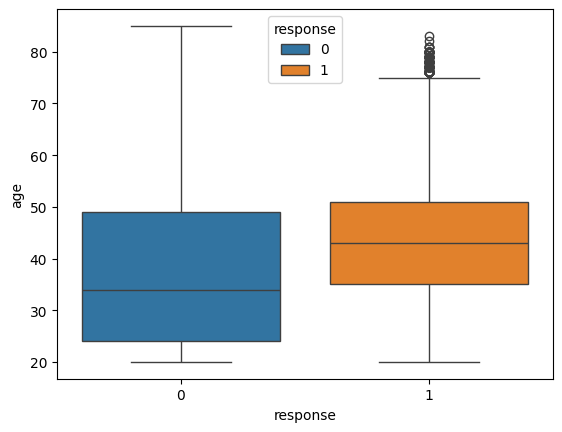

In [20]:
#age

sns.boxplot(x='response', y='age', hue = 'response', data = df4);

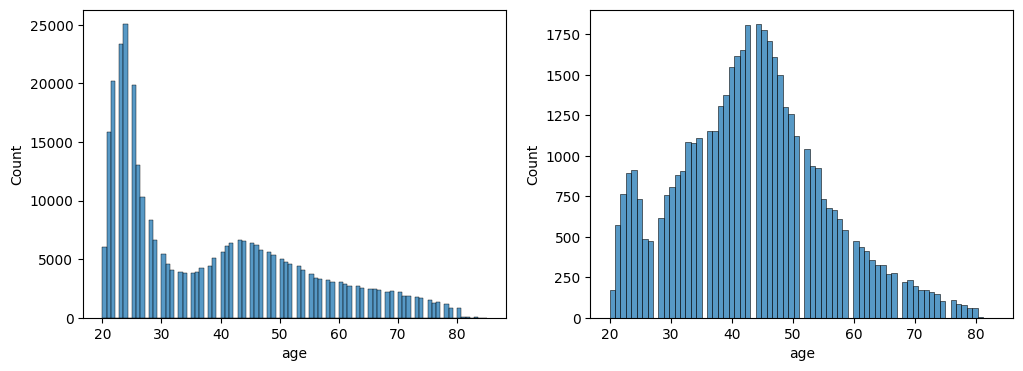

In [21]:
#understanding age distribuition
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux1, ax=axes[0]);

aux2 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux2, ax=axes[1]);

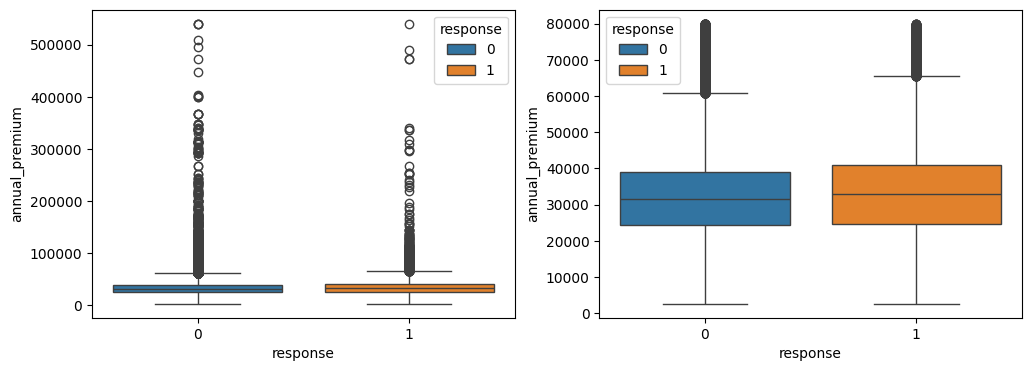

In [22]:
#annual premium
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(x='response', y='annual_premium', hue = 'response', data = df4, ax=axes[0]);

#filtering the annual premium variable to visualize better
aux1 = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', hue = 'response', data = aux1, ax=axes[1]);

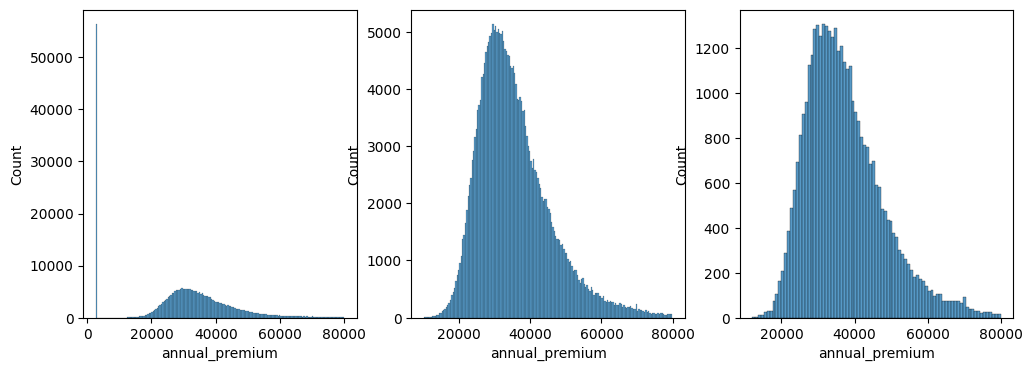

In [23]:
#annual premium
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

aux2 = aux1.loc[aux1['response'] == 0, 'annual_premium']
sns.histplot(aux2, ax=axes[0]);

aux4 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux3 = aux4.loc[aux4['response'] == 0, 'annual_premium']
sns.histplot(aux3, ax=axes[1]);

aux3 = aux4.loc[aux4['response'] == 1, 'annual_premium']
sns.histplot(aux3, ax=axes[2]);

In [39]:
#driving license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['percentage'] = aux['driving_license']/aux['driving_license'].sum()
aux

,response,driving_license,percentage
0,0,333628,0.877283
1,1,46669,0.122717


In [25]:
#region

In [26]:
#previous insured